## Problem Set 2
### MACS 30100, Dr. Evans
### Leoson Hoay

**Importing necessary packages:**

In [1]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

### Problem (1) 
**Some income data, lognormal distribution, and hypothesis testing.**

**(a)**

<IPython.core.display.Javascript object>


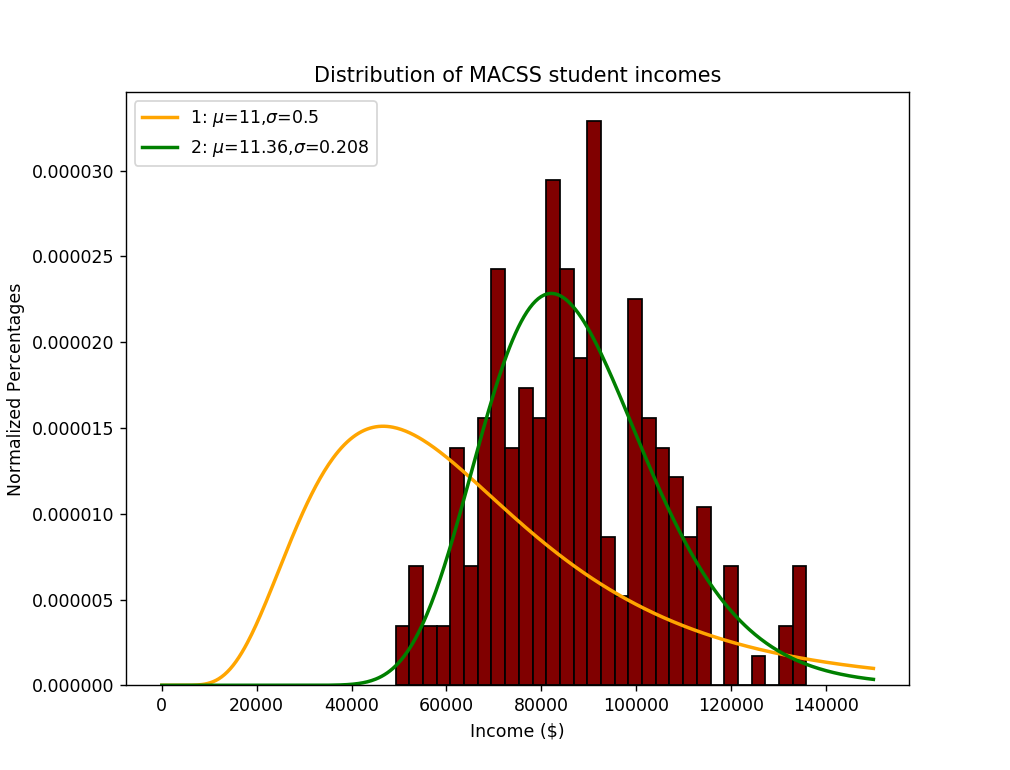

In [2]:
incomes = np.genfromtxt('../../ProblemSets/PS2/incomes.txt')

%matplotlib notebook
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = "maroon", normed=True)
plt.title('Distribution of MACSS student incomes')
plt.xlabel('Income (\$)')
plt.ylabel('Normalized Percentages')
plt.show()

**(b)**

In [3]:
# pdf values function
def lognormal_pdf(xvals, mu, sigma):
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi)) * np.exp( - (np.log(xvals) - mu)**2 
                                                                / (2 * sigma**2)))
    
    return pdf_vals

# plot pdf distribution
pdf_incomes = np.linspace(0.001, 150000.0, 500)
mu_1, sigma_1 = 11.0, 0.5
plt.plot(pdf_incomes, lognormal_pdf(pdf_incomes, mu_1, sigma_1), linewidth = 2, color = 'orange',label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

# log likelihood value function
def log_lik_lognormal(xvals, mu, sigma):
    pdf_vals = lognormal_pdf(xvals, mu, sigma)
    log_likelihood = np.log(pdf_vals).sum()

    return log_likelihood

# calculate log likelihood
print(log_lik_lognormal(incomes, mu_1, sigma_1))

-2385.856997808558


The log likelihood value for this parameterization is **-2385.856997808558**.

**(c)**

In [4]:
# criterion function that returns negative log likelihood
def criterion(params, args):
    mu, sigma = params
    log_likelihood_val = log_lik_lognormal(args, mu, sigma)
    negative_log_likelihood = -log_likelihood_val
    
    return negative_log_likelihood

mu_init = 11.0  
sig_init = 0.5 
params_init = np.array([mu_init, sig_init])
mle_args = incomes
results = opt.minimize(criterion, params_init, args=mle_args,bounds=((None,None), (0.05,None)))
mu_MLE, sig_MLE = results.x
plt.plot(pdf_incomes, lognormal_pdf(pdf_incomes, mu_MLE, sig_MLE), linewidth = 2, color = 'g',label='2: $\mu$=11.36,$\sigma$=0.208')
plt.legend(loc='upper left')

In [5]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])

In [6]:
print('Variance-Covariance Matrix:')
print('VCV(MLE) = ', vcv_mle)

Variance-Covariance Matrix:
VCV(MLE) =  [[2.14193230e-04 1.67777259e-06]
 [1.67777259e-06 1.06945553e-04]]


In [7]:
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)
print('Log-likelihood: ', log_lik_lognormal(incomes, mu_MLE, sig_MLE))

Standard error for mu estimate =  0.01463534179748769
Standard error for sigma estimate =  0.010341448282528037
mu_MLE= 11.359022964862739  sig_MLE= 0.20817732032361122
Log-likelihood:  -2241.7193013573615


**(d)**

In [8]:
log_lik_h0 = log_lik_lognormal(incomes, 11, 0.5)
log_lik_mle = log_lik_lognormal(incomes, mu_MLE, sig_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
# perform chi-squared test
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)

In [9]:
print('p-value = ' + '{0:.3f}'.format(pval_h0))

p-value = 0.000


Since p-value <<<< 0.01, we can **reject the null hypothesis that mu and sigma are 11 and 0.5 respectively.**

**(e)**

In [10]:
# obtain cdf area by summing up cumulative pdf values
less_75 = (lognormal_pdf(pdf_incomes[pdf_incomes < 75000], mu_MLE, sig_MLE).sum() 
           / lognormal_pdf(pdf_incomes, mu_MLE, sig_MLE).sum())

more_100 = (lognormal_pdf(pdf_incomes[pdf_incomes > 100000], mu_MLE, sig_MLE).sum()
            / lognormal_pdf(pdf_incomes, mu_MLE, sig_MLE).sum())

print(less_75)
print(more_100)

0.2611601551885381
0.22785189903441166


The probability that MACSS graduates will earn less than \$75,000 is ~ 26.12 percent. 
The probability that MACSS graduates will earn more than \$100,000 is ~ 22.79 percent.

### Problem (2) 
**Linear regression and MLE**

**(a)**

In [11]:
sick = np.loadtxt("../../ProblemSets/PS2/sick.txt", skiprows = 1 , delimiter  = ',')

In [12]:
# define new log likelihood function
def log_likelihood(xvals, mu, sigma):
    pdf_vals = sts.norm.pdf(xvals, loc = mu, scale = sigma)
    log_likelihood_val = np.log(pdf_vals).sum()
    
    return log_likelihood_val

# define the criterion function
def criterion_2(params, *args):
    beta_0, beta_1, beta_2, beta_3, sigma = params
    s_week, s_age, s_children, s_avg_tem = args
    n = len(s_week)
    sigma2 = sigma * sigma
    xvals = s_week - beta_0 - beta_1 * s_age - beta_2 * s_children - beta_3 * s_avg_tem
    log_likelihood_val = -n/2*np.log(2*np.pi*sigma2) - 1/(2*sigma2)*(xvals).T @ (xvals)
    negative_log_likelihood = -log_likelihood_val
                         
    return negative_log_likelihood

In [13]:
params_0 = np.array([0, 1, 1, 1, 1])
LR_args = (sick[:,0], sick[:,1], sick[:,2], sick[:,3])
result_2 = opt.minimize(criterion_2, params_0, args=LR_args, method = 'BFGS')
b_0_LR, b_1_LR, b_2_LR, b_LR, sig_0_LR = result_2.x
sig_0_LR = np.absolute(sig_0_LR)

res = sick[:,0] - b_0_LR - b_1_LR * sick[:,1] - b_2_LR *  sick[:,2] - b_LR * sick[:,3]

h_inv = result_2.hess_inv
OffDiagNeg = -np.ones(h_inv.shape) + np.eye(h_inv.shape[0])*2

print("Parameters: ", b_0_LR, b_1_LR, b_2_LR, b_LR,sig_0_LR*sig_0_LR)

Parameters:  0.25164660137488415 0.012933359280317275 0.4005018827479995 -0.009991679154085852 9.10691046156176e-06


$\beta_0$ = 0.2516 <br>
$\beta_1$ = 0.0129 <br>
$\beta_2$ = 0.4005 <br>
$\beta_3$ = -0.0099 <br>
$\sigma^2$ = 9.1e-06.

In [14]:
print("Variance covariance matrix: ", result_2.hess_inv)

Variance covariance matrix:  [[ 8.17021071e-07  6.94703561e-09 -1.57887050e-07 -1.78564610e-08
  -1.87543296e-10]
 [ 6.94703561e-09  3.76254914e-09 -3.42361475e-08 -2.35069884e-09
  -3.34818060e-10]
 [-1.57887050e-07 -3.42361475e-08  3.59348062e-07  2.16820854e-08
   2.71986791e-09]
 [-1.78564610e-08 -2.35069884e-09  2.16820854e-08  1.76144648e-09
   2.22905021e-10]
 [-1.87543296e-10 -3.34818060e-10  2.71986791e-09  2.22905021e-10
   2.08888726e-08]]


In [15]:
print("Log Likelihood value: ", log_likelihood(res, 0, sig_0_LR))

Log Likelihood value:  876.8650466197506


**(b)**

In [16]:
res_2 = sick[:,0] - 1 
log_lik_h0_2 = log_likelihood(res_2, 0, 0.1)
log_lik_mle_2 = log_likelihood(res, 0, sig_0_LR)
LR_val_2 = 2 * (log_lik_mle_2 - log_lik_h0_2)
# perform chi-squared test
pval_h0_2 = 1.0 - sts.chi2.cdf(LR_val_2, 5)
print('p-value = ' + '{0:.3f}'.format(pval_h0_2))

p-value = 0.000


Since p-value <<<< 0.01, we can **reject the null hypothesis that  $\beta_0$ = 1.0, $\sigma^2$ = 0.01 and $\beta_1$ , $\beta_2$ , $\beta_3$ = 0.**